## Permutation testing

This script performs permutation testing experiments: in order to assess the true differences between clusters, we need to test for differences in random clusters and compare them to the differences obtained in the actual clustering:

1. We permute the data in random clusters. Do 1000 iterations.
2. We test for differences in each iteration, for each of features.
3. We compare the obtained differences in the real clusters to the distribution of differences over the real ones.

In order to exactly reproduce the figures with the exact same values, the cells of the notebook should be reproduced in the same order. Seed can be changed to test that results are robust.

In [ ]:
import numpy as np
import pandas as pd
import sys
sys.path.append('..')
from utils.data_utils import load_all_data
from utils.utils import compute_simlr, feat_ranking
from scipy.stats import ttest_1samp, wilcoxon, ttest_ind, mannwhitneyu
from scipy.stats import percentileofscore
from sklearn.utils import shuffle

**Initialization and loading of variables**

In [ ]:
# Parameters of the procedure
clusters = 4
rd_seed = 1714                                          # Random seed for experiment replication
test_name = 'wilc'
feature = 'volume'                                      # either blood or volume

# Paths
existing_cluster = True                                              # Compute the clustering again or use an existing one
cluster_path = "/home/gerard/Documents/EXPERIMENTS/SIMLR-AD/cimlr4/"# Path of the existing cluster, if applicable
covariate_path = "../data/useddata_homo_abeta_plasma_meta.csv"       # Path of the covariance data frame (.csv)
feature_path = "../data/aseg_volume.csv"                # Path of the feature file, generated with freesurfer (.csv)


covariate_data, cov_names, feature_data, feature_names = load_all_data(covariate_path, feature_path)
feature_data['DX'] = covariate_data.DX_bl.values

if existing_cluster:
    # Load existent
    c_data = pd.read_csv(cluster_path + 'cluster_data.csv')
    c_data.reset_index(inplace=True)

    ## Load S, F data
    S = np.load(cluster_path + 'S_matrix.npy')
    ydata = np.load(cluster_path + 'ydata_matrix.npy')
    F = np.load(cluster_path + 'F_matrix.npy')
else:
    # Compute base clustering
    y_b, S, F, ydata, alpha = compute_simlr(
        np.array(covariate_data[cov_names]), clusters)

    
# Hand made feature names
feature_names_fig = ["Left Lateral Ventricle", "Left Inf. Lateral Ventricle", "Left Cerebellum WM", "Left Cerebellum Cortex", "Left Thalamus Proper", "Left Caudate", 
                 "Left Putamen", "Left Pallidum", "3rd Ventricle", "4th Ventricle", "Brain Stem", "Left Hippocampus", "Left Amygdala", "Cerebrospinal Fluid",
                 "Left Accumbens area", "Left Ventral Diencephalon", "Left Vessel", "Left Choroid Plexus", "Right Lateral Ventricle", "Right Inf. Lateral Ventricle",
                 "Right Cerebellum WM", "Right Cerebellum Cortex", "Right Thalamus Proper", "Right Caudate", "Right Putamen", "Right Pallidum", "Right Hippocampus", 
                 "Right Amygdala", "Right Accumbens Area", "Right Ventral Diencephalon", "Right Vessel", "Right-Choroid-Plexus", "WM hypointensities", "Optic Chiasm",
                 "CC Posterior", "CC Mid Posterior", "CC Central", "CC Mid Anterior", "CC Anterior"]

Do the tests, according to the procedure. We have two big groups to compare:
* Each cluster against others (whole population).
* Within clusters, compare against each other groups (12 problems)
* Different DX groups on whole population (3 problems)
* For each DX group, one cluster against the other

## FIRST FIGURE: Each cluster against others

In [3]:
# Number of iterations of the permutation tests
it = 1000

problems = [1,2,3,4]

features = feature_names
# problems = [(4, 'nA', 'CN'), (4, 'nA', 'LMCI'), (4, 'nA', 'AD')]
# problems = [(1, 4, 'CN'), (1, 4, 'LMCI'), (1, 4, 'AD')]
# problems = [(1, 3, 'CN'), (1, 3, 'LMCI'), (1, 3, 'AD')]
# problems = [(2, 3, 'CN'), (2, 3, 'LMCI'), (2, 3, 'AD')]
# problems = [(2, 4, 'CN'), (2, 4, 'LMCI'), (2, 4, 'AD')]
# problems = [(3, 4, 'CN'), (3, 4, 'LMCI'), (3, 4, 'AD')]
data = feature_data

results =np.zeros((it, len(problems), len(features)))

# random seeds for reproducibility
np.random.seed(rd_seed)

# The randomized clusters need to be the same size of the original clusters
for i in range(it):
    # Create a random permutation
    ## Try shuffling between clusters AND the DX
    dx_list = ['CN', 'LMCI', 'AD']
    
    data_shuffled = data.copy()
    
    for dx in dx_list:
        indexs = c_data.DX.values == dx
        to_shuffle = data_shuffled[indexs]
        to_shuffle = shuffle(to_shuffle)
        data_shuffled.loc[indexs] = to_shuffle.values
    
    j = 0
    for p in problems:
        c1 = data_shuffled[c_data['C'].values == p]
        c2 = data_shuffled[c_data['C'].values != p]
        k = 0
        for f in features:
            # Do test
            u, p_value = mannwhitneyu(c1[f].values, c2[f].values)            
            # Add the test to the structure
            results[i,j,k] = p_value
            k = k + 1
        j = j + 1

## Compute over the normal clusters
results_base = np.zeros((len(problems), len(features)))

# The randomized clusters need to be the same size of the original clusters
j = 0
for p in problems:
    # Select the features
    c1 = data[c_data['C'].values == p]
    c2 = data[c_data['C'].values != p]
    k = 0
    for f in features:
        # Do test
        u, p_value = mannwhitneyu(c1[f].values, c2[f].values)
    
        # Add the test to the structure
        results_base[j,k] = p_value
        k += 1
    j += 1

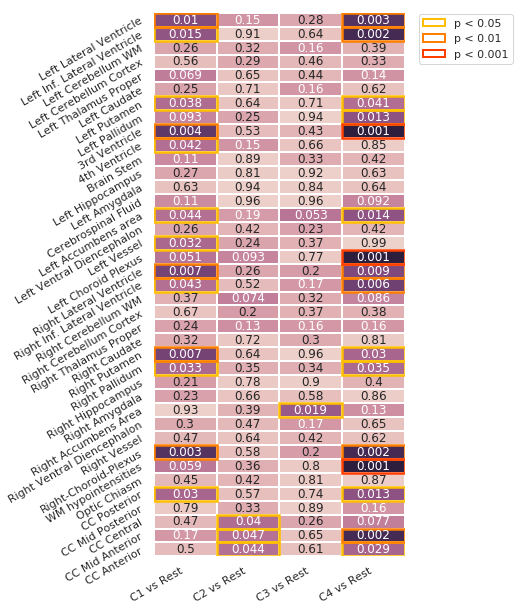

In [4]:
#Once we have the results, we need to:
# For each feature and problem, do the tests over the original data and compare them to the distribution.
# Create a figure with the distribution for each problem and feature with a bright point the true obtained difference.

# Percentile files
percentiles = np.zeros((len(problems), len(features)))
percentiles_base = np.zeros((len(problems), len(features)))

# Structures containing the statistically significant files:
p005 = []
p001 = []
p0001 = []

for p in range(len(problems)):
    for f in range(len(features)):
        iterations = results[:,p,f]
        score = percentileofscore(iterations, results_base[p,f],kind='weak')
        if score == 0:
            score = 0.1
        percentiles_base[p,f] = score / 100
        percentiles[p,f] = -np.log10(score / 100)
        if np.isnan(percentiles[p,f]):
            percentiles[p,f] = 0.001
        
        # Save is significant        
        if percentiles_base[p,f] <= 0.001:
            p0001.append((p,f))
        elif percentiles_base[p,f] <= 0.01:
            p001.append((p,f))
        elif percentiles_base[p,f] <= 0.05:
            p005.append((p,f))

# Create dataframe
df_percentiles = pd.DataFrame(data=percentiles, index=problems, columns=features)
df_percentiles.to_csv('percentiles.csv')

# Craete heatmap of the percentiles of each feature vs all problems


import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
%matplotlib inline
sns.set(style="white")

prob_names = ["C1 vs Rest", "C2 vs Rest", "C3 vs Rest", "C4 vs Rest"]

cmap = sns.cubehelix_palette(11, reverse=False, as_cmap=True)
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(4.5, 10))
ax2 = sns.heatmap(df_percentiles.T, annot=percentiles_base.T, linewidths=1, ax=ax, cbar=False, cmap=cmap,
                  cbar_kws={"ticks":[0,0.5,1,1.3,1.5,2,2.5,3]}, xticklabels=prob_names, yticklabels=feature_names_fig, vmin = 0, vmax = 3)
plt.yticks(rotation=30) 
plt.xticks(rotation=30, ha="right") 

# Draw rectangles about the significant values. The significant values should be added AUTOMATICALLY

from matplotlib.patches import Rectangle, Patch


colors = sns.color_palette("autumn_r", 3)
## Add rectangles 
for sq in p005:
    ax2.add_patch(Rectangle((sq[0], sq[1]), 1, 1, fill=False, edgecolor=colors[0], lw=2.5))

for sq in p001:
    ax2.add_patch(Rectangle((sq[0], sq[1]), 1, 1, fill=False, edgecolor=colors[1], lw=2.5))

for sq in p0001:
    ax2.add_patch(Rectangle((sq[0], sq[1]), 1, 1, fill=False, edgecolor=colors[2], lw=2.5))

p1 = Patch(edgecolor=colors[0], fill=False, label='p < 0.05', linewidth=2)
p2 = Patch(edgecolor=colors[1], fill=False, label='p < 0.01', linewidth=2)
p3 = Patch(edgecolor=colors[2], fill=False, label='p < 0.001', linewidth=2)

plt.legend([p1, p2, p3], ['p < 0.05','p < 0.01','p < 0.001'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.1)
## Also create a legend for the rectangles. Would be great to have three factors: <0.05, <0.01, <0.001
plt.savefig('clusteragainstothers.png', dpi=300, bbox_inches='tight')
# plt.savefig('clusteragainstothers.eps', format='eps', dpi=300, bbox_inches='tight')


## SECOND FIGURE: Within clusters, against other groups

In [ ]:
# Number of iterations of the permutation tests
it = 1000

problems = [1,2,3,4]

features = feature_names
problems = [(1,'CN','AD'), (2,'CN','AD'), (3,'CN','AD'),(4,'CN','AD'),
            (1,'CN','LMCI'), (2,'CN','LMCI'),(3,'CN','LMCI'), (4,'CN','LMCI'), 
            (1,'LMCI','AD'), (2,'LMCI','AD'), (3,'LMCI','AD'), (4,'LMCI','AD')]

data = feature_data

results = np.zeros((it, len(problems), len(features)))

# The randomized clusters need to be the same size of the original clusters
for i in range(it):
    # Create a random permutation
    ## Try shuffling between clusters AND the DX
    dx_list = ['CN', 'LMCI', 'AD']
    
    # data_shuffled = shuffle(data)
    
    data_shuffled = data.copy()
    
    for dx in dx_list:
        indexs = c_data.DX.values == dx
        to_shuffle = data_shuffled[indexs]
        to_shuffle = shuffle(to_shuffle)
        data_shuffled.loc[indexs] = to_shuffle.values
    
    j = 0
    for p in problems:
        # Select the features
        c1 = data_shuffled[c_data['C'].values == p[0]]
        c2 = data_shuffled[c_data['C'].values == p[0]]
        c1 = c1[c1.DX.values == p[1]]
        c2 = c2[c2.DX.values == p[2]]
        k = 0
        for f in features:
            # Do test
            u, p_value = mannwhitneyu(c1[f].values, c2[f].values)            
            # Add the test to the structure
            results[i,j,k] = p_value
            k = k + 1
        j = j + 1

## Compute over the normal clusters
results_base = np.zeros((len(problems), len(features)))

# The randomized clusters need to be the same size of the original clusters
j = 0
for p in problems:
    # Select the features
    c1 = data[c_data['C'].values == p[0]]
    c2 = data[c_data['C'].values == p[0]]
    c1 = c1[c1.DX.values == p[1]]
    c2 = c2[c2.DX.values == p[2]]
    k = 0
    for f in features:
        # Do test
        u, p_value = mannwhitneyu(c1[f].values, c2[f].values)
    
        # Add the test to the structure
        results_base[j,k] = p_value
        k += 1
    j += 1

In [ ]:

#Once we have the results, we need to:
#* For each feature and problem, do the tests over the original data and compare them to the distribution.
#* Create a figure with the distribution for each problem and feature with a bright point the true obtained difference.

# Percentile files
percentiles = np.zeros((len(problems), len(features)))
percentiles_base = np.zeros((len(problems), len(features)))

# Structures containing the statistically significant files:
p005 = []
p001 = []
p0001 = []

for p in range(len(problems)):
    for f in range(len(features)):
        iterations = results[:,p,f]
        score = percentileofscore(iterations, results_base[p,f],kind='weak')
        if score == 0:
            score = 0.1
        percentiles_base[p,f] = score / 100
        percentiles[p,f] = -np.log10(score / 100)
        if np.isnan(percentiles[p,f]):
            percentiles[p,f] = 0.001
        
        # Save is significant        
        if percentiles_base[p,f] <= 0.001:
            p0001.append((p,f))
        elif percentiles_base[p,f] <= 0.01:
            p001.append((p,f))
        elif percentiles_base[p,f] <= 0.05:
            p005.append((p,f))

# Create dataframe
df_percentiles = pd.DataFrame(data=percentiles, index=problems, columns=features)
df_percentiles.to_csv('percentiles.csv')

# Craete heatmap of the percentiles of each feature vs all problems


import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
%matplotlib inline
sns.set(style="white")
sns.set(font_scale=0.7)
prob_names = ["C1 - CN vs AD", "C2 - CN vs AD", "C3 - CN vs AD", "C4 - CN vs AD",
              "C1 - CN vs MCI", "C2 - CN vs MCI", "C3 - CN vs MCI", "C4 - CN vs MCI",
              "C1 - MCI vs AD", "C2 - MCI vs AD", "C3 - MCI vs AD", "C4 - MCI vs AD"]

cmap = sns.cubehelix_palette(11, reverse=False, as_cmap=True)
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(5.5, 10))
ax2 = sns.heatmap(df_percentiles.T, annot=percentiles_base.T, linewidths=1, ax=ax, cbar=False, cmap=cmap,
                  cbar_kws={"ticks":[0,0.5,1,1.3,1.5,2,2.5,3]}, xticklabels=prob_names, yticklabels=feature_names_fig, vmin = 0, vmax = 3)
plt.yticks(rotation=30) 
plt.xticks(rotation=30, ha="right") 

# Draw rectangles about the significant values. The significant values should be added AUTOMATICALLY

from matplotlib.patches import Rectangle, Patch
colors = sns.color_palette("autumn_r", 3)
## Add rectangles 
for sq in p005:
    ax2.add_patch(Rectangle((sq[0], sq[1]), 1, 1, fill=False, edgecolor=colors[0], lw=2.5))

for sq in p001:
    ax2.add_patch(Rectangle((sq[0], sq[1]), 1, 1, fill=False, edgecolor=colors[1], lw=2.5))

for sq in p0001:
    ax2.add_patch(Rectangle((sq[0], sq[1]), 1, 1, fill=False, edgecolor=colors[2], lw=2.5))

p1 = Patch(edgecolor=colors[0], fill=False, label='p < 0.05', linewidth=2)
p2 = Patch(edgecolor=colors[1], fill=False, label='p < 0.01', linewidth=2)
p3 = Patch(edgecolor=colors[2], fill=False, label='p < 0.001', linewidth=2)

plt.legend([p1, p2, p3], ['p < 0.05','p < 0.01','p < 0.001'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.1)
## Also create a legend for the rectangles. Would be great to have three factors: <0.05, <0.01, <0.001
plt.savefig('intraclustergroups.png', dpi=300, bbox_inches='tight')
# plt.savefig('intraclustergroups.eps', format='eps', dpi=300, bbox_inches='tight')


## THIRD FIGURE: Different DX groups over the whole population

In [8]:
# Number of iterations of the permutation tests

features = feature_names
problems = [('CN','AD'), ('CN', 'LMCI'), ('LMCI', 'AD')]

data = feature_data

## Compute over the normal clusters
results_base = np.zeros((len(problems), len(features)))

# The randomized clusters need to be the same size of the original clusters
j = 0
for p in problems:
    # Select the features
    c1 = data[data.DX.values == p[0]]
    c2 = data[data.DX.values == p[1]]
    k = 0
    for f in features:
        # Do test
        u, p_value = mannwhitneyu(c1[f].values, c2[f].values)
        # Add the test to the structure
        results_base[j,k] = p_value
        k += 1
    j += 1

In [ ]:

#Once we have the results, we need to:
#* For each feature and problem, do the tests over the original data and compare them to the distribution.
#* Create a figure with the distribution for each problem and feature with a bright point the true obtained difference.

# Percentile files
percentiles = np.zeros((len(problems), len(features)))
percentiles_base = np.zeros((len(problems), len(features)))

# Structures containing the statistically significant files:
p005 = []
p001 = []
p0001 = []

for p in range(len(problems)):
    for f in range(len(features)):
        score = results_base[p,f]
        if score == 0:
            score = 0.1
        percentiles[p,f] = -np.log10(score / 100)
        percentiles_base[p,f] = score
        # Save is significant        
        if percentiles_base[p,f] <= 0.001:
            p0001.append((p,f))
        elif percentiles_base[p,f] <= 0.01:
            p001.append((p,f))
        elif percentiles_base[p,f] <= 0.05:
            p005.append((p,f))

# Create dataframe
df_percentiles = pd.DataFrame(data=percentiles, index=problems, columns=features)
df_percentiles.to_csv('percentiles.csv')

# Craete heatmap of the percentiles of each feature vs all problems


import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
%matplotlib inline
sns.set(style="white")

sns.set(font_scale=0.9)
f, ax = plt.subplots(figsize=(5, 10))

prob_names = ["CN vs AD", "CN vs MCI", "MCI vs AD"]

cmap = sns.cubehelix_palette(11, reverse=False, as_cmap=True)
# Draw a heatmap with the numeric values in each cell
ax2 = sns.heatmap(df_percentiles.T, annot=percentiles_base.T, linewidths=1, ax=ax, cbar=False, cmap=cmap,
                  cbar_kws={"ticks":[0,0.5,1,1.3,1.5,2,2.5,3]}, xticklabels=prob_names, yticklabels=feature_names_fig, vmin = 0, vmax = 6)
plt.yticks(rotation=30) 
plt.xticks(rotation=30) 

# Draw rectangles about the significant values. The significant values should be added AUTOMATICALLY

from matplotlib.patches import Rectangle, Patch


colors = sns.color_palette("autumn_r", 3)
## Add rectangles 
for sq in p005:
    ax2.add_patch(Rectangle((sq[0], sq[1]), 1, 1, fill=False, edgecolor=colors[0], lw=2.5))

for sq in p001:
    ax2.add_patch(Rectangle((sq[0], sq[1]), 1, 1, fill=False, edgecolor=colors[1], lw=2.5))

for sq in p0001:
    ax2.add_patch(Rectangle((sq[0], sq[1]), 1, 1, fill=False, edgecolor=colors[2], lw=2.5))

p1 = Patch(edgecolor=colors[0], fill=False, label='p < 0.05', linewidth=2)
p2 = Patch(edgecolor=colors[1], fill=False, label='p < 0.01', linewidth=2)
p3 = Patch(edgecolor=colors[2], fill=False, label='p < 0.001', linewidth=2)

plt.legend([p1, p2, p3], ['p < 0.05','p < 0.01','p < 0.001'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.1)
## Also create a legend for the rectangles. Would be great to have three factors: <0.05, <0.01, <0.001
plt.savefig('betweengroups_wholepop.png', dpi=300, bbox_inches='tight')
# plt.savefig('betweengroups_wholepop.eps', format='eps', dpi=300, bbox_inches='tight')


In [ ]:
## FOURTH FIGURE: For each DX group, one cluster against the other

In [ ]:
# Number of iterations of the permutation tests
it = 1000

features = feature_names
problems = [(1,'CN'), (1,'LMCI'), (1,'AD'),
            (2,'CN'), (2,'LMCI'), (2,'AD'),
            (3,'CN'), (3,'LMCI'), (3,'AD'),
            (4,'CN'), (4,'LMCI'), (4,'AD')]

data = feature_data

results =np.zeros((it, len(problems), len(features)))

# The randomized clusters need to be the same size of the original clusters
for i in range(it):
    # Create a random permutation
    ## Try shuffling between clusters AND the DX
    dx_list = ['CN', 'LMCI', 'AD']
    
    # data_shuffled = shuffle(data)
    
    data_shuffled = data.copy()
    
    for dx in dx_list:
        indexs = c_data.DX.values == dx
        to_shuffle = data_shuffled[indexs]
        to_shuffle = shuffle(to_shuffle)
        data_shuffled.loc[indexs] = to_shuffle.values
    
    j = 0
    for p in problems:
        # Select the features
        c1 = data_shuffled[c_data['C'].values == p[0]]
        c2 = data_shuffled[c_data['C'].values != p[0]]
        c1 = c1[c1.DX.values == p[1]]
        c2 = c2[c2.DX.values == p[1]]
        k = 0
        for f in features:
            # Do test
            u, p_value = mannwhitneyu(c1[f].values, c2[f].values)            
            # Add the test to the structure
            results[i,j,k] = p_value
            k = k + 1
        j = j + 1

## Compute over the normal clusters
results_base = np.zeros((len(problems), len(features)))

# The randomized clusters need to be the same size of the original clusters
j = 0
for p in problems:
    # Select the features
    c1 = data[c_data['C'].values == p[0]]
    c2 = data[c_data['C'].values != p[0]]
    c1 = c1[c1.DX.values == p[1]]
    c2 = c2[c2.DX.values == p[1]]
    k = 0
    for f in features:
        # Do test
        u, p_value = mannwhitneyu(c1[f].values, c2[f].values)
    
        # Add the test to the structure
        results_base[j,k] = p_value
        k += 1
    j += 1

In [ ]:

#Once we have the results, we need to:
#* For each feature and problem, do the tests over the original data and compare them to the distribution.
#* Create a figure with the distribution for each problem and feature with a bright point the true obtained difference.

# Percentile files
percentiles = np.zeros((len(problems), len(features)))
percentiles_base = np.zeros((len(problems), len(features)))

# Structures containing the statistically significant files:
p005 = []
p001 = []
p0001 = []

for p in range(len(problems)):
    for f in range(len(features)):
        iterations = results[:,p,f]
        score = percentileofscore(iterations, results_base[p,f],kind='weak')
        if score == 0:
            score = 0.1
        percentiles_base[p,f] = score / 100
        percentiles[p,f] = -np.log10(score / 100)
        if np.isnan(percentiles[p,f]):
            percentiles[p,f] = 0.001
        
        # Save is significant        
        if percentiles_base[p,f] <= 0.001:
            p0001.append((p,f))
        elif percentiles_base[p,f] <= 0.01:
            p001.append((p,f))
        elif percentiles_base[p,f] <= 0.05:
            p005.append((p,f))

# Create dataframe
df_percentiles = pd.DataFrame(data=percentiles, index=problems, columns=features)
df_percentiles.to_csv('percentiles.csv')

# Craete heatmap of the percentiles of each feature vs all problems

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
%matplotlib inline
sns.set(style="white")
sns.set(font_scale=0.7)
f, ax = plt.subplots(figsize=(5.5, 10))

prob_names = ["CN - C1 vs Rest", "MCI - C1 vs Rest", "AD - C1 vs Rest",
             "CN - C2 vs Rest", "MCI - C2 vs Rest", "AD - C2 vs Rest",
             "CN - C3 vs Rest", "MCI - C3 vs Rest", "AD - C3 vs Rest",
             "CN - C4 vs Rest", "MCI - C4 vs Rest", "AD - C4 vs Rest"]

cmap = sns.cubehelix_palette(11, reverse=False, as_cmap=True)
# Draw a heatmap with the numeric values in each cell
ax2 = sns.heatmap(df_percentiles.T, annot=percentiles_base.T, linewidths=1, ax=ax, cbar=False, cmap=cmap,
                  cbar_kws={"ticks":[0,0.5,1,1.3,1.5,2,2.5,3]}, xticklabels=prob_names, yticklabels=feature_names_fig, vmin = 0, vmax = 3)
plt.yticks(rotation=30) 
plt.xticks(rotation=30, ha="right") 

# Draw rectangles about the significant values. The significant values should be added AUTOMATICALLY

from matplotlib.patches import Rectangle, Patch


colors = sns.color_palette("autumn_r", 3)
## Add rectangles 
for sq in p005:
    ax2.add_patch(Rectangle((sq[0], sq[1]), 1, 1, fill=False, edgecolor=colors[0], lw=2.5))

for sq in p001:
    ax2.add_patch(Rectangle((sq[0], sq[1]), 1, 1, fill=False, edgecolor=colors[1], lw=2.5))

for sq in p0001:
    ax2.add_patch(Rectangle((sq[0], sq[1]), 1, 1, fill=False, edgecolor=colors[2], lw=2.5))

p1 = Patch(edgecolor=colors[0], fill=False, label='p < 0.05', linewidth=2)
p2 = Patch(edgecolor=colors[1], fill=False, label='p < 0.01', linewidth=2)
p3 = Patch(edgecolor=colors[2], fill=False, label='p < 0.001', linewidth=2)

plt.legend([p1, p2, p3], ['p < 0.05','p < 0.01','p < 0.001'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.1)
## Also create a legend for the rectangles. Would be great to have three factors: <0.05, <0.01, <0.001
plt.savefig('groupsdxcluster_againstrest.png', dpi=300, bbox_inches='tight')
# plt.savefig('groupsdxcluster_againstrest.eps', format='eps', dpi=300, bbox_inches='tight')
